# Climate and Central Banks - an analysis of monetary policy in response to climate change

#### Attention! --> remember to insert your Fred API key in Chapter 3!

In [15]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#
import warnings
warnings.filterwarnings("ignore")

## Chapter 1

### AD - AS Model

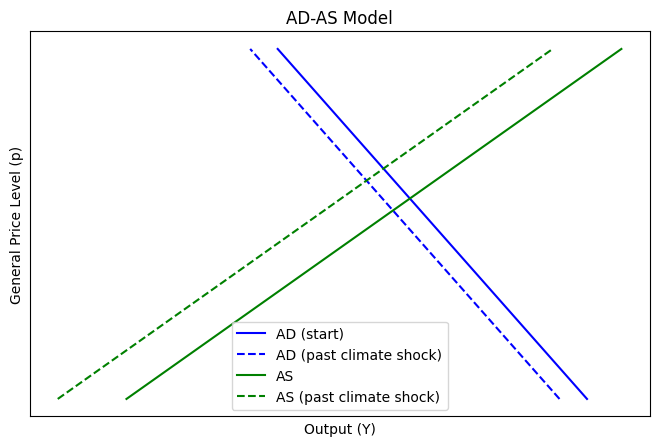

In [16]:
P = np.linspace(0.5, 5, 100)

# AD Curve
AD1 = 5 - 0.5 * P
AD2 = 4.8 - 0.5 * P  # contractions

# AS Curve (stable)
AS1 = 1 + 0.8 * P
AS2 = 0.5 + 0.8 * P

# Plot
plt.figure(figsize=(8, 5))
plt.plot(AD1, P, label = 'AD (start)', color='blue')
plt.plot(AD2, P, label = 'AD (past climate shock)', color = 'blue', linestyle = '--')
plt.plot(AS1, P, label = 'AS', color='green')
plt.plot(AS2, P, label = 'AS (past climate shock)', color = 'green', linestyle = "--")


plt.title('AD-AS Model')
plt.xlabel("Output (Y)")
plt.ylabel("General Price Level (p)")
plt.legend()

# No number in axis --> they are invented!
plt.xticks([])
plt.yticks([])

plt.show()

## Chapter 3

### Federal Funds Rate (USA)

Here you have to insert your Fred API Key:

In [17]:
# your Fred API: 
# fred = Fred(api_key="YOUR KEY") 

fred = Fred(api_key=#"") 

SyntaxError: incomplete input (3623051366.py, line 4)

In [ ]:
# Download Fed Funds historical data (code: "FEDFUNDS")
policy_rate = fred.get_series('FEDFUNDS')

# print(policy_rate.head())

policy_rate.plot(title='Federal Funds Rate (USA)', figsize=(10,4))
plt.ylabel('%')
plt.grid(True)
plt.show()

### Industrial Production

In [ ]:
production = fred.get_series("INDPRO")

#print(production.head())

production.plot(title='Industrial Production (USA)', figsize=(10,4))
plt.ylabel('%')
plt.grid(True)
plt.show()

### Consumer Price Index (CPI)

In [ ]:
cpi = fred.get_series('CPIAUCSL')
cpi = cpi.rename("CPI")
#print(cpi.head())

# COmputing the Inflation Rate
Inflation_Rate = cpi.pct_change(periods=12) * 100
Inflation_Rate = Inflation_Rate.rename("Inflation Rate")

# Creating a unique DataFrame
df_cpi = pd.concat([cpi, Inflation_Rate], axis=1)
print(df_cpi.tail())

df_cpi["Inflation Rate"].plot(title="USA Inflation Rate", figsize=(10, 4))
plt.ylabel("%")
plt.grid(True)
plt.show()

### Anomaly Monthly Temperature

In [ ]:
temperature = pd.read_csv("Surface Temperature.txt", delim_whitespace=True, on_bad_lines='skip', usecols= [0,1,2])

temperature.columns = temperature.columns.astype(str)
temperature = temperature.rename(columns = {"Year,":"Year", "Month,":"Month","Anomaly,":"Anomaly_Temp"})
temperature["Date"] = pd.to_datetime(dict(year = temperature["Year"], month = temperature["Month"], day = 1))
temperature = temperature.drop(columns=["Year", "Month"])
temperature = temperature.set_index("Date")
#print(temperature.head())

plt.figure(figsize = (10,4))
plt.plot(temperature)
plt.title("Anomaly Monthly Temperature")
plt.xlabel("Date")
plt.ylabel("Variations")
plt.show()

### Extreme Climatic Events

In [ ]:
Climate_All_Data = pd.read_excel("Extreme Climatic Events.csv")
Climate_ev = Climate_All_Data[["Start Year", "Start Month"]].copy()

#print(Climate_ev[["Start Year", "Start Month"]].isna().sum())

Climate_ev = Climate_ev.dropna(subset=["Start Year", "Start Month"])
Climate_ev["Start Year"] = Climate_ev["Start Year"].astype(int)
Climate_ev["Start Month"] = Climate_ev["Start Month"].astype(int)

#Climate_ev.head()

In [ ]:
Climate_ev["Data"] = pd.to_datetime(
    Climate_ev["Start Year"].astype(str) + "-" +
    Climate_ev["Start Month"].astype(str) + "-01")

Climate_ev = Climate_ev.groupby("Data").size().rename("N_Events").to_frame()

Climate_ev["Dummy_Events"] = (Climate_ev["N_Events"] > 0).astype(int)

Climate_ev.head()

## DataFrame

We have to create a new DataFrame

In [ ]:
df = pd.concat([policy_rate, production, df_cpi, temperature, Climate_ev], axis = 1, join = "inner")
df = df.rename(columns = {0:"Policy_Rate", 1:"Production"})
#df.head()

Computing Lag of climate variable for simulating the delay effects & Lag of inflation to check autocorrelation

In [ ]:
df["Anomaly_Temp_L1"] = df["Anomaly_Temp"].shift(1)
df["N_Events_L1"] = df["N_Events"].shift(1)
df["Dummy_Events_L1"] = df["Dummy_Events"].shift(1)
#
df["Inflation_Rate_L1"] = df["Inflation Rate"].shift(1)
#df.head()

Computing Delta Industrial production & delta policy rate 

In [ ]:
df["Delta_Production"] = df["Production"].pct_change() * 100
df["Delta_Policy"] = df["Policy_Rate"].diff()
df = df.dropna()
df.head()

# Econometrics

In [ ]:
sns.boxplot(
    data=df,
    x="Dummy_Events",
    y="Delta_Policy"
)

It seems that there isn't any evidence of variation of interest rates between the two groups.
The graph show that the presence of extreme events does't influence sistematically the variation of interest rate.

In [ ]:
sns.scatterplot(
    data=df,
    x="N_Events",
    y="Delta_Policy",
    alpha=0.5
)

In [ ]:
sns.scatterplot(
    data=df,
    x="Anomaly_Temp_L1",
    y="Delta_Policy",
    alpha=0.5
)

plt.xticks(ticks=np.arange(-0.4, 1.6, 0.5))


### OLS

In [ ]:
# Variables 
X = sm.add_constant(df[['Dummy_Events', 'Anomaly_Temp_L1']]) # indipendent
y = df['Policy_Rate'] # dipendent

# OLS
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':12}) # HAC: correction for Heteroschedasticity & AutoCorrelation

print(model.summary())

There isn't any statistically evidence of a realtionship between extreme climate events and change in interest rate. However, OLS model shows that in months of extreme climate event, the average of interest rate level is higher. This could be interpretated as a possible structural effects on the policy monetary choice.

### ARIMAX

In [ ]:
# Choosing the best ARIMAX model with "pmdarima" library
stepwise_model = auto_arima(
    y, exogenous=X,
    start_p=1, start_q=0,
    max_p=4, max_q=3,
    seasonal=False,
    d=0, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
stepwise_model.summary()

In [ ]:
# ARIMAX(4,0,3)

df_arimax = df[['Policy_Rate', 'Dummy_Events', 'Anomaly_Temp_L1']].dropna()
y = df_arimax['Policy_Rate']
X = df_arimax[['Dummy_Events', 'Anomaly_Temp_L1']]

# Estimation of model ARIMAX(p,d,q) with exogen variables
model = SARIMAX(
    endog=y,
    exog=X,
    order=(4, 0, 3),
    enforce_stationarity=False,
    enforce_invertibility=False,
    cov_type='robust' 
)
result = model.fit(disp=False)

print(result.summary())

Climate variables ( frequency of the extreme events and anomlay temperature) aren't statistically significant.
Climate shocks don't produce a direct and systematic effect on the monetary policy in the short term.
However, the coherence with the sign of coefficients with the OLS analysis could be enterpreted as a structural effect (this should be studied in more detail).